In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import moyal

In [42]:
# def get_adc_spectra(file_path):
#     # Read the file and extract x and y data
#     data = np.loadtxt(file_path, delimiter="\t")
#     x, y = data[:, 0], data[:, 1]

#     # Normalize the y-values
#     y = y / np.max(y)

#     # Ask the user for an x range
#     user_input = input(
#         "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
#     )
#     if user_input:
#         try:
#             x_min, x_max = map(float, user_input.split(","))
#             # Filter the data based on the provided x_range
#             mask = (x >= x_min) & (x <= x_max)
#             x, y = x[mask], y[mask]

#             # Perform a Moyal fit for the Landau curve
#             from scipy.optimize import curve_fit
#             from scipy.stats import moyal

#             def moyal_func(x, mu, sigma, amplitude):
#                 return amplitude * moyal.pdf(x, mu, sigma)

#             # Provide better initial guesses for the parameters
#             initial_mu = x[np.argmax(y)]  # Peak position
#             initial_sigma = np.std(x) / 2  # Approximate spread
#             initial_amplitude = 1.0  # Normalized peak height

#             # Add bounds to constrain the parameters
#             bounds = ([x.min(), 0, 0], [x.max(), np.inf, np.inf])

#             popt, pcov = curve_fit(
#                 moyal_func,
#                 x,
#                 y,
#                 p0=[initial_mu, initial_sigma, initial_amplitude],
#                 bounds=bounds,
#             )

#             # Print the fit parameters
#             print("Moyal Fit Parameters:")
#             print(f"Mu (Location): {popt[0]}")
#             print(f"Sigma (Scale): {popt[1]}")
#             print(f"Amplitude: {popt[2]}")

#             # Plot the ADC spectra and the Moyal fit
#             plt.figure()
#             plt.plot(x, y, label="ADC Spectra")
#             plt.plot(x, moyal_func(x, *popt), label="Moyal Fit", linestyle="--")
#             plt.xlabel("X-axis")
#             plt.ylabel("Normalized Y-axis")
#             plt.title("ADC Spectra with Moyal Fit")
#             plt.legend()
#             plt.grid(True)  # Add grid lines
#             plt.show()
#         except ValueError:
#             print("Invalid input. Skipping the fit.")
#     else:
#         print("No range provided. Skipping the fit.")

#     # Plot the ADC spectra without the fit
#     plt.figure()
#     plt.plot(x, y, label="ADC Spectra")
#     plt.xlabel("X-axis")
#     plt.ylabel("Normalized Y-axis")
#     plt.title("ADC Spectra")
#     plt.legend()
#     plt.grid(True)  # Add grid lines
#     plt.show()

#     return x, y

In [109]:
def get_adc_spectra(file_path, xlim=None, ylim=None, FWHM=False, normalize_y=False):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "ADC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    user_input = input(
        "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
    )
    fit_done = False
    fit_label = "Moyal Fit (on selected range)"
    FWHM_val = None
    fwhm_x1, fwhm_x2, half_max = None, None, None

    if user_input:
        try:
            x_min, x_max = map(float, user_input.split(","))
            mask = (x >= x_min) & (x <= x_max)
            x_fit, y_fit = x[mask], y[mask]

            if len(x_fit) == 0:
                print("No data in the specified range. Skipping fit.")
            else:

                def moyal_func(x, mu, sigma, amplitude):
                    return amplitude * moyal.pdf(x, mu, sigma)

                initial_mu = x_fit[np.argmax(y_fit)]
                initial_sigma = np.std(x_fit) / 2
                initial_amplitude = np.max(
                    y_fit
                )  # Use actual (not normalized) amplitude

                bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])

                popt, pcov = curve_fit(
                    moyal_func,
                    x_fit,
                    y_fit,
                    p0=[initial_mu, initial_sigma, initial_amplitude],
                    bounds=bounds,
                )

                mu, sigma, amplitude = popt

                print("Moyal Fit Parameters:")
                print(f"Mu (Location): {mu}")
                print(f"Sigma (Scale): {sigma}")
                print(f"Amplitude: {amplitude}")

                if FWHM:
                    x_fine = np.linspace(min(x_fit), max(x_fit), 5000)
                    y_fine = moyal_func(x_fine, *popt)
                    half_max = np.max(y_fine) / 2
                    above_half = np.where(y_fine >= half_max)[0]
                    if len(above_half) > 1:
                        fwhm_x1 = x_fine[above_half[0]]
                        r_idx = above_half[-1]
                        if r_idx + 1 < len(x_fine):
                            x_right_l = x_fine[r_idx]
                            x_right_r = x_fine[r_idx + 1]
                            y_right_l = y_fine[r_idx]
                            y_right_r = y_fine[r_idx + 1]
                            fwhm_x2 = x_right_l + (half_max - y_right_l) * (
                                x_right_r - x_right_l
                            ) / (y_right_r - y_right_l)
                        else:
                            fwhm_x2 = x_fine[r_idx]
                        FWHM_val = fwhm_x2 - fwhm_x1
                        print(f"FWHM: {FWHM_val}")
                        print(f"Right FWHM intersection at x = {fwhm_x2:.4f}")
                    else:
                        print("Could not determine FWHM.")

                fit_label = (
                    f"Moyal Fit (on selected range)\n"
                    f"$\\mu$ = {mu:.2f}\n"
                    f"$\\sigma$ = {sigma:.2f}\n"
                    f"Amplitude = {amplitude:.2f}"
                )
                if FWHM and FWHM_val is not None:
                    fit_label += f"\nFWHM = {FWHM_val:.2f}"

                fit_done = True
        except ValueError:
            print("Invalid input. Skipping fit.")

    plt.figure()
    plt.plot(
        x,
        y,
        label="ADC Spectra",
        linestyle=":",
        color="steelblue",
        alpha=1.0,
        linewidth=1,
    )
    if fit_done:
        plt.plot(
            x_fit,
            moyal_func(x_fit, *popt),
            color="red",
            label=fit_label,
            linewidth=1.75,
        )
        if (
            FWHM
            and FWHM_val is not None
            and fwhm_x1 is not None
            and fwhm_x2 is not None
        ):
            plt.hlines(
                half_max,
                fwhm_x1,
                fwhm_x2,
                color="green",
                linestyle="dotted",
                linewidth=2,
                label="FWHM",
            )
            plt.vlines(
                [fwhm_x1, fwhm_x2],
                0,
                half_max,
                color="green",
                linestyle="dotted",
                linewidth=1,
            )
            plt.scatter(fwhm_x2, half_max, color="green", zorder=5)
            plt.annotate(
                f"Edge = {fwhm_x2:.2f}",
                (fwhm_x2, half_max),
                textcoords="offset points",
                xytext=(15, 5),
                ha="left",
                color="green",
                fontsize=9,
                arrowprops=dict(arrowstyle="->", color="green"),
            )

    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)

    plt.legend(loc="best", fontsize=9)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()
    return x, y

Moyal Fit Parameters:
Mu (Location): 286.27073344304125
Sigma (Scale): 21.286330391772985
Amplitude: 7803.62416465307
FWHM: 76.4069384965826
Right FWHM intersection at x = 334.8986


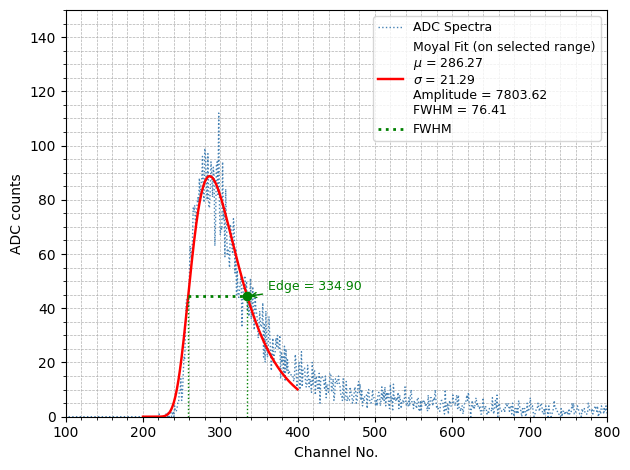

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [110]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-on/free_spectra_lightON_chA_adc_a.txt",
    xlim=(100, 800),
    ylim=(0, 150),
    FWHM=True,
)

Moyal Fit Parameters:
Mu (Location): 288.2842736153144
Sigma (Scale): 22.590516989231542
Amplitude: 7654.24373547823
FWHM: 81.07978815033835
Right FWHM intersection at x = 339.8916


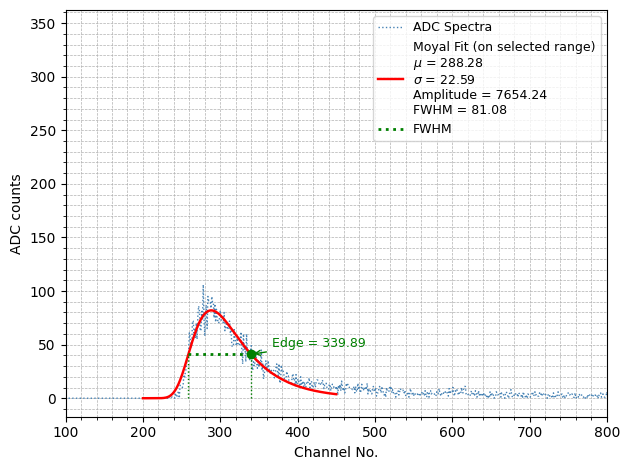

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [108]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-off/free_spectra_lightOFF_chA_adc_a.txt",
    xlim=(100, 800),
    # ylim=(0, 0.45),
    FWHM=True,
    normalize_y=False,
)